Loaded 15549 orders

Profit - Sales: 0.14
Quantity - Sales: 0.12
Discount - Profit Ratio: -0.02



/tmp/ipython-input-3746881429.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_new['shipping_date'].fillna(data_new['shipping_date'].mode()[0], inplace=True)
/tmp/ipython-input-3746881429.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Prepared 49 features from 15549 orders

Step 4: Finding customer groups...
5D PCA explains 23.5% of data variance

DBSCAN quality: 0.37
K-Means quality: 0.56
Agglomerative quality: 0.56
DBSCAN found 16 groups



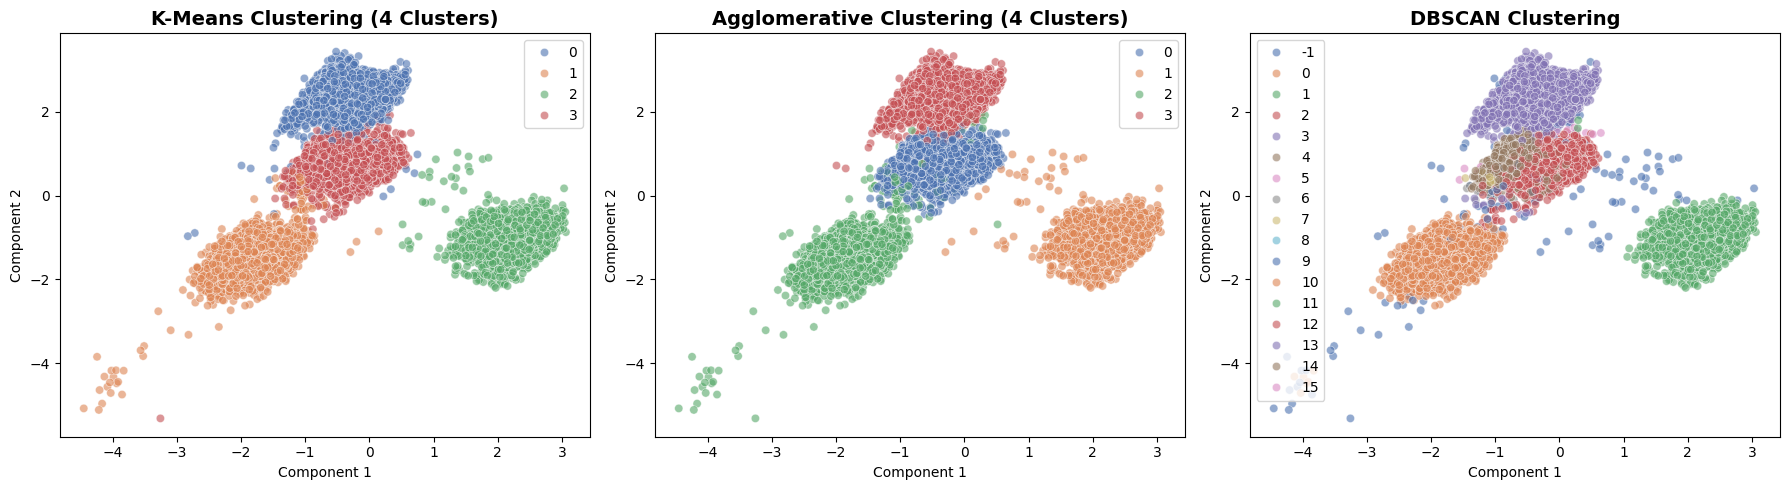

Average values per cluster:
         profit_per_order  sales_per_customer  category_id  customer_id  \
cluster                                                                   
-1                 -90.71              357.59        35.55      7364.50   
 0                  24.66              183.41        31.03      6383.60   
 1                  23.64              176.36        29.73      6231.84   
 2                  22.32              177.29        30.27      6270.35   
 3                  21.29              174.10        35.14      7560.83   
 4                  32.68              164.37        30.30      6041.27   
 5                -249.45               77.07        29.55      6490.47   
 6                  59.15              210.74        23.57      5634.80   
 7                  11.28              110.62        21.81      6553.66   
 8                  18.13              123.22        27.32      5008.20   
 9                 211.83              485.46         9.00      5933.37 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Load data
data_new = pd.read_csv('/content/incom2024_delay_example_dataset.csv')
print(f"Loaded {len(data_new)} orders\n")


# STEP 1: Clean dates


data_new['shipping_date'] = pd.to_datetime(data_new['shipping_date'], errors='coerce', utc=True)
data_new['order_date'] = pd.to_datetime(data_new['order_date'], errors='coerce', utc=True)

# Fill missing dates
data_new['shipping_date'].fillna(data_new['shipping_date'].mode()[0], inplace=True)
data_new['order_date'].fillna(data_new['order_date'].mode()[0], inplace=True)

# Calculate shipping time
data_new['shipping_time_days'] = (data_new['shipping_date'] - data_new['order_date']).dt.days
data_new['shipping_time_days'].fillna(data_new['shipping_time_days'].mean(), inplace=True)

# Extract date parts
data_new['order_month'] = data_new['order_date'].dt.month
data_new['order_year'] = data_new['order_date'].dt.year
data_new['order_day_of_week'] = data_new['order_date'].dt.dayofweek



# STEP 2: Check correlations


important_cols = ['profit_per_order', 'sales', 'order_item_quantity',
                  'order_item_discount', 'order_item_profit_ratio']
correlations = data_new[important_cols].corr()

print(f"Profit - Sales: {correlations.loc['profit_per_order', 'sales']:.2f}")
print(f"Quantity - Sales: {correlations.loc['order_item_quantity', 'sales']:.2f}")
print(f"Discount - Profit Ratio: {correlations.loc['order_item_discount', 'order_item_profit_ratio']:.2f}")
print()


# STEP 3: Prepare data for ML



# Numbers to use
number_features = ['profit_per_order', 'sales_per_customer', 'order_item_discount_rate',
                   'order_item_profit_ratio', 'order_item_quantity', 'sales',
                   'shipping_time_days', 'order_month', 'order_year', 'order_day_of_week']

# Categories to convert
category_features = ['payment_type', 'market', 'order_region', 'shipping_mode', 'customer_segment']
categories_encoded = pd.get_dummies(data_new[category_features], prefix=category_features)

# Combine everything
all_features = pd.concat([data_new[number_features], categories_encoded], axis=1)

# Scale to same range
scaler = StandardScaler()
features_scaled = scaler.fit_transform(all_features)

print(f"Prepared {features_scaled.shape[1]} features from {features_scaled.shape[0]} orders\n")


# STEP 4: Find clusters

# Reduce to 5D for analysis (but still plot in 2D)
pca = PCA(n_components=5)
features_5d = pca.fit_transform(features_scaled)
variance_explained = pca.explained_variance_ratio_.sum()

print(f"5D PCA explains {variance_explained:.1%} of data variance\n")


# Try K-Means (finds 4 groups) on PCA-reduced data
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_groups = kmeans.fit_predict(features_5d)

# Try Agglomerative (finds 4 groups) on PCA-reduced data
agg = AgglomerativeClustering(n_clusters=4)
agg_groups = agg.fit_predict(features_5d)

# Try DBSCAN (finds groups automatically) on PCA-reduced data
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_groups = dbscan.fit_predict(features_5d)


# Check quality
kmeans_quality = silhouette_score(features_5d, kmeans_groups)
agg_quality = silhouette_score(features_5d, agg_groups)

# DBSCAN silhouette score (only if more than 1 cluster found, excluding noise)
if len(set(dbscan_groups)) > 1:
    dbscan_quality = silhouette_score(features_5d, dbscan_groups)
    print(f"DBSCAN quality: {dbscan_quality:.2f}")
else:
    print("DBSCAN found 1 or fewer clusters (excluding noise), cannot calculate silhouette score.")

dbscan_unique = len(set(dbscan_groups)) - (1 if -1 in dbscan_groups else 0)

print(f"K-Means quality: {kmeans_quality:.2f}")
print(f"Agglomerative quality: {agg_quality:.2f}")
print(f"DBSCAN found {dbscan_unique} groups")
print()


# STEP 5: Visualize clusters


# Reduce to 2D for plotting
pca_plot = PCA(n_components=2)
features_2d = pca_plot.fit_transform(features_scaled)


# Create plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=kmeans_groups,
                palette='deep', ax=ax1, alpha=0.6, legend='brief')
ax1.set_title('K-Means Clustering (4 Clusters)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')

# Agglomerative
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=agg_groups,
                palette='deep', ax=ax2, alpha=0.6, legend='brief')
ax2.set_title('Agglomerative Clustering (4 Clusters)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')

# DBSCAN
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=dbscan_groups,
                palette='deep', ax=ax3, alpha=0.6, legend='brief')
ax3.set_title('DBSCAN Clustering', fontsize=14, fontweight='bold')
ax3.set_xlabel('Component 1')
ax3.set_ylabel('Component 2')

plt.tight_layout()
plt.show()


# STEP 6: Understand the clusters



# Add cluster labels
data_new['cluster'] = dbscan_groups

# Get average values per cluster
numeric_columns = data_new.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(['label'], errors='ignore')


cluster_summary = data_new.groupby('cluster')[numeric_columns].mean()


print("Average values per cluster:")
print(cluster_summary.round(2))

print("\n Analysis complete!")

Loaded 15549 orders

✓ Processing time calculated

✓ Using 14 numbers and 7 categories



/tmp/ipython-input-2532630553.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['shipping_date'].fillna(data['shipping_date'].mode()[0], inplace=True)
/tmp/ipython-input-2532630553.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

Training: 12439 orders
Testing: 3110 orders

Preparation pipeline ready

Model trained


Accuracy: 59.4%

Detailed Results:
              precision    recall  f1-score   support

  Early (-1)       0.42      0.51      0.46       709
 On Time (0)       0.39      0.07      0.12       606
 Delayed (1)       0.67      0.80      0.73      1795

    accuracy                           0.59      3110
   macro avg       0.49      0.46      0.44      3110
weighted avg       0.56      0.59      0.55      3110



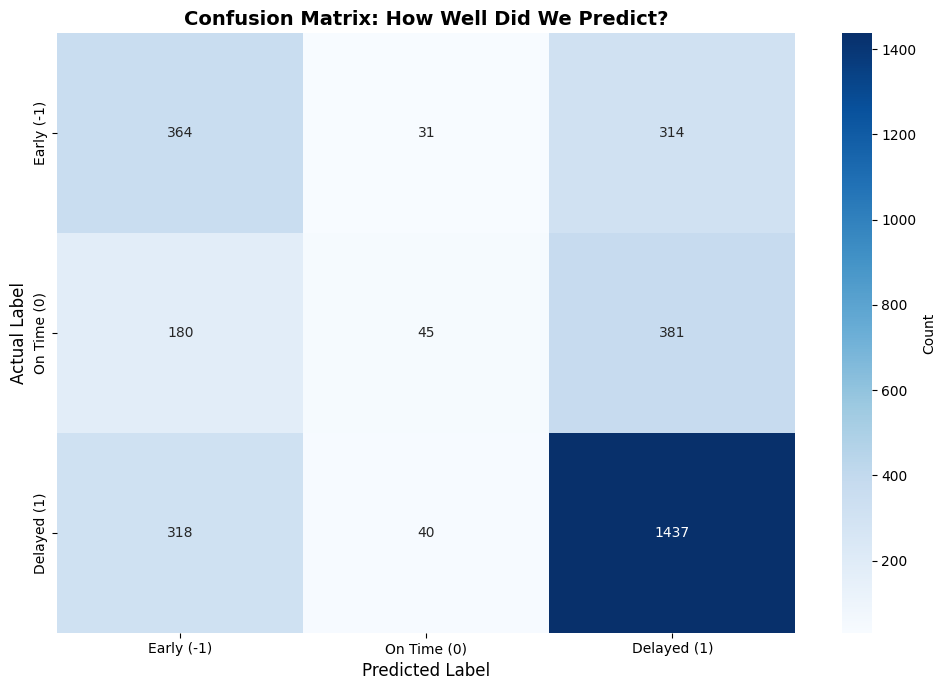

Confusion matrix saved as 'confusion_matrix.png'



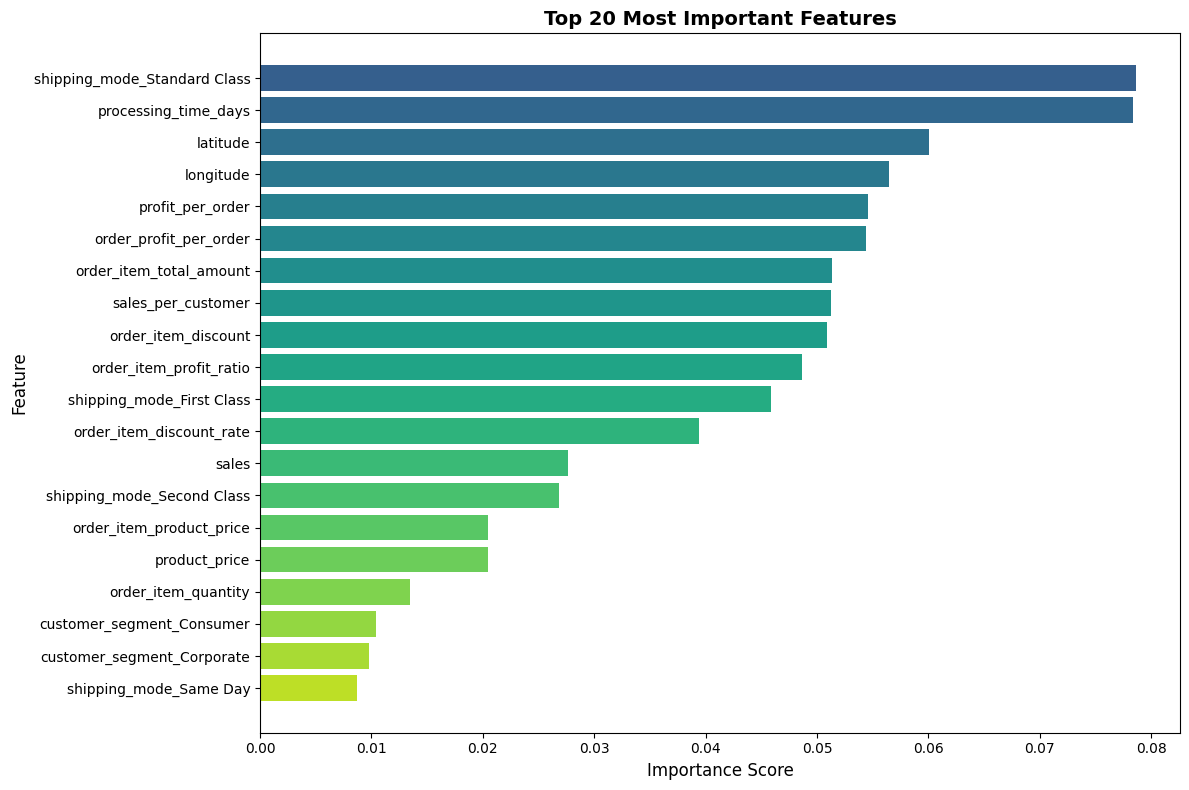

Feature importance saved as 'feature_importance.png'

Analysis complete!

Check your folder for:
confusion_matrix.png
feature_importance.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load data

data = pd.read_csv("incom2024_delay_example_dataset.csv")
print(f"Loaded {len(data)} orders\n")


# STEP 1: Calculate processing time


# Convert to dates
data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce', utc=True)
data['shipping_date'] = pd.to_datetime(data['shipping_date'], errors='coerce', utc=True)

# Fill missing dates
data['shipping_date'].fillna(data['shipping_date'].mode()[0], inplace=True)
data['order_date'].fillna(data['order_date'].mode()[0], inplace=True)

# Calculate days between order and shipping
data['processing_time_days'] = (data['shipping_date'] - data['order_date']).dt.days
data['processing_time_days'].fillna(data['processing_time_days'].mean(), inplace=True)

print("✓ Processing time calculated\n")


# STEP 2: Choose our features


# Numbers we'll use
numbers = [
    'profit_per_order', 'sales_per_customer', 'latitude', 'longitude',
    'order_item_discount', 'order_item_discount_rate', 'order_item_product_price',
    'order_item_profit_ratio', 'order_item_quantity', 'sales',
    'order_item_total_amount', 'order_profit_per_order', 'product_price',
    'processing_time_days'
]

# Categories we'll use
categories = [
    'payment_type', 'customer_segment', 'department_name', 'market',
    'order_region', 'order_status', 'shipping_mode'
]

# What we're trying to predict
target = 'label'
labels = ['Early (-1)', 'On Time (0)', 'Delayed (1)']

# Separate features and target
X = data[numbers + categories]
y = data[target]

print(f"✓ Using {len(numbers)} numbers and {len(categories)} categories\n")


# STEP 3: Split the data


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} orders")
print(f"Testing: {len(X_test)} orders\n")


# STEP 4: Prepare data for machine


# Scale numbers to same range
number_prep = Pipeline([('scaler', StandardScaler())])

# Convert categories to numbers
category_prep = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine both preparations
prep = ColumnTransformer([
    ('numbers', number_prep, numbers),
    ('categories', category_prep, categories)
])

print("Preparation pipeline ready\n")


# STEP 5: Train the model


# Create full pipeline: prep + model
model = Pipeline([
    ('prep', prep),
    ('forest', RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1))
])

# Train it
model.fit(X_train, y_train)
print("Model trained\n")


# STEP 6: Check how well it works


# Make predictions
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, target_names=labels)

print(f"\nAccuracy: {accuracy:.1%}")
print("\nDetailed Results:")
print(report)


# STEP 7: Visualize confusion matrix


# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot it
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix: How Well Did We Predict?', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as 'confusion_matrix.png'\n")


# STEP 8: See which features matter most


# Get feature names after encoding
encoded_categories = model.named_steps['prep'] \
                          .named_transformers_['categories'] \
                          .named_steps['encoder'] \
                          .get_feature_names_out(categories)

all_features = numbers + list(encoded_categories)

# Get importance scores
importance = model.named_steps['forest'].feature_importances_

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importance
})

# Get top 20
top_20 = importance_df.sort_values('Importance', ascending=False).head(20)

# Plot it
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 20))
plt.barh(range(20), top_20['Importance'].values, color=colors)
plt.yticks(range(20), top_20['Feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance saved as 'feature_importance.png'\n")

# Done!

print("Analysis complete!")

print("\nCheck your folder for:")
print("confusion_matrix.png")
print("feature_importance.png")

Loading data...
✓ Loaded 15549 orders

Step 1: Grouping rare categories...
✓ Grouped rare locations into 'Others'

Step 2: Removing unhelpful features...
✓ Removed 10 categories that don't predict delays
✓ Removed 11 duplicate numbers and 4 text columns

Step 3: Creating processing time feature...
✓ Calculated days between order and shipping

Step 4: Converting categories to numbers...
✓ 18 features ready
✓ 6573 not delayed, 8976 delayed

Step 5: Training 5 different models...

Training Decision Tree...
  Training accuracy: 71.3%
  Testing accuracy: 72.0%

  Results on test data:
              precision    recall  f1-score   support

 Not Delayed       0.63      0.86      0.72      1660
     Delayed       0.85      0.62      0.72      2228

    accuracy                           0.72      3888
   macro avg       0.74      0.74      0.72      3888
weighted avg       0.76      0.72      0.72      3888


Training Random Forest...
  Training accuracy: 70.6%
  Testing accuracy: 71.2%

  Res

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


  Training accuracy: 70.9%
  Testing accuracy: 71.3%

  Results on test data:
              precision    recall  f1-score   support

 Not Delayed       0.63      0.79      0.70      1660
     Delayed       0.81      0.65      0.72      2228

    accuracy                           0.71      3888
   macro avg       0.72      0.72      0.71      3888
weighted avg       0.73      0.71      0.71      3888


Training Gradient Boosting...
  Training accuracy: 73.5%
  Testing accuracy: 72.2%

  Results on test data:
              precision    recall  f1-score   support

 Not Delayed       0.64      0.78      0.71      1660
     Delayed       0.80      0.68      0.74      2228

    accuracy                           0.72      3888
   macro avg       0.72      0.73      0.72      3888
weighted avg       0.74      0.72      0.72      3888


Training Stacking...
  Training accuracy: 18.0%
  Testing accuracy: 59.8%

  Results on test data:
              precision    recall  f1-score   support

 Not

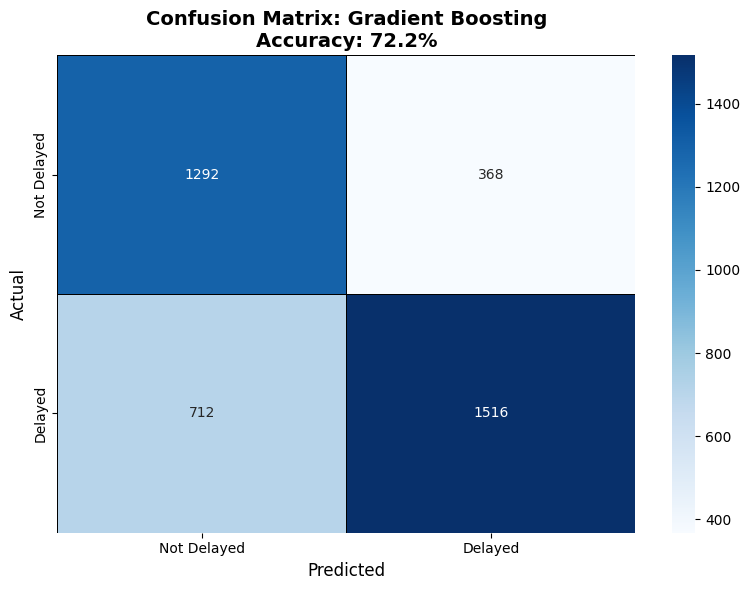

✓ Confusion matrix created

✓ Analysis complete!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load data

data = pd.read_csv('incom2024_delay_example_dataset.csv')
info = pd.read_csv('incom2024_delay_variable_description.csv')
print(f"Loaded {len(data)} orders\n")


# STEP 1: Clean up categories



# Combine rare locations into "Others"
locations = {'customer_city': 50, 'customer_state': 50, 'order_city': 50,
             'order_country': 50, 'order_region': 100, 'order_state': 50}

for location, min_count in locations.items():
    counts = data[location].value_counts()
    rare = counts[counts < min_count].index
    data[location] = data[location].apply(lambda x: 'Others' if x in rare else x)

print("Grouped rare locations into 'Others'\n")


# STEP 2: Remove features that don't help



# Test which categories are useful
categories = list(info[info['type'] == 'categorical']['variable_name'])
useless = []

for cat in categories:
    if cat != 'label':
        table = pd.crosstab(data[cat], data['label'])
        _, p_value, _, _ = chi2_contingency(table)
        if p_value >= 0.1:  # Not related to delays
            useless.append(cat)

data = data.drop(useless, axis=1, errors='ignore')
print(f"Removed {len(useless)} categories that don't predict delays")

# Remove duplicate number columns
duplicates = ['order_id', 'order_customer_id', 'product_card_id', 'category_id',
              'order_item_cardprod_id', 'order_item_total_amount', 'order_item_product_price',
              'sales', 'product_price', 'product_category_id', 'profit_per_order']

# Remove text columns
text = ['category_name', 'customer_zipcode', 'department_name', 'product_name']

data = data.drop(duplicates + text, axis=1, errors='ignore')
print(f"Removed {len(duplicates)} duplicate numbers and {len(text)} text columns\n")


# STEP 3: Calculate processing time


data['order_date'] = pd.to_datetime(data['order_date'], utc=True)
data['shipping_date'] = pd.to_datetime(data['shipping_date'], utc=True)
data['processingTime'] = (data['shipping_date'] - data['order_date']).dt.days
data = data.drop(['order_date', 'shipping_date'], axis=1)

print("Calculated days between order and shipping\n")


# STEP 4: Convert everything to numbers


# One-hot encoding
data_encoded = pd.get_dummies(data, drop_first=True, dtype=int)

# Simplify target: Early/OnTime = 0, Delayed = 1
data_encoded['label'] = data_encoded['label'].apply(lambda x: 0 if x in [-1, 0] else 1)

# Split features and target
features = data_encoded.drop('label', axis=1)
target = data_encoded['label']

delays = target.value_counts()
print(f"{features.shape[1]} features ready")
print(f"{delays[0]} not delayed, {delays[1]} delayed\n")

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=1
)


# STEP 5: Train multiple models



# Our models
models = {
    'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced', random_state=1),
    'Random Forest': RandomForestClassifier(n_estimators=100, ccp_alpha=0.01, class_weight='balanced', random_state=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, algorithm='SAMME', random_state=1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1),
    'Stacking': StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=10, class_weight='balanced', ccp_alpha=0.1, random_state=42)),
            ('svm', SVC(class_weight='balanced', gamma='auto', random_state=42)),
            ('nb', GaussianNB())
        ],
        final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    )
}

# Train each model
scores = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    scores[name] = test_score

    print(f"  Training accuracy: {train_score:.1%}")
    print(f"  Testing accuracy: {test_score:.1%}")

    predictions = model.predict(X_test)
    print(f"\n  Results on test data:")
    print(classification_report(y_test, predictions, target_names=['Not Delayed', 'Delayed']))
    print()


# STEP 6: Find the best model


print("RESULTS SUMMARY")


# Sort by accuracy
sorted_models = sorted(scores.items(), key=lambda x: x[1], reverse=True)
for i, (name, score) in enumerate(sorted_models, 1):
    marker = "🏆" if i == 1 else f"{i}."
    print(f"{marker} {name}: {score:.1%}")

best_name = sorted_models[0][0]
best_model = models[best_name]
print(f"\nBest model: {best_name}\n")


# STEP 7: Visualize best model

predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'],
            linewidths=0.5, linecolor='black')

accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
plt.title(f'Confusion Matrix: {best_name}\nAccuracy: {accuracy:.1%}',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

print(" Confusion matrix created\n")

# Done!

print("Analysis complete!")


Loaded 15549 orders

Rare locations grouped

Removed 25 unhelpful features

Processing time calculated

18 features ready

Training accuracy: 73.5%
Testing accuracy: 72.2%

Delay Rates by Shipping Mode:
                Actual Delay %  Predicted Delay %
shipping_mode                                    
First Class               98.4              100.0
Same Day                  51.6               51.1
Second Class              76.7              100.0
Standard Class            39.7               15.6



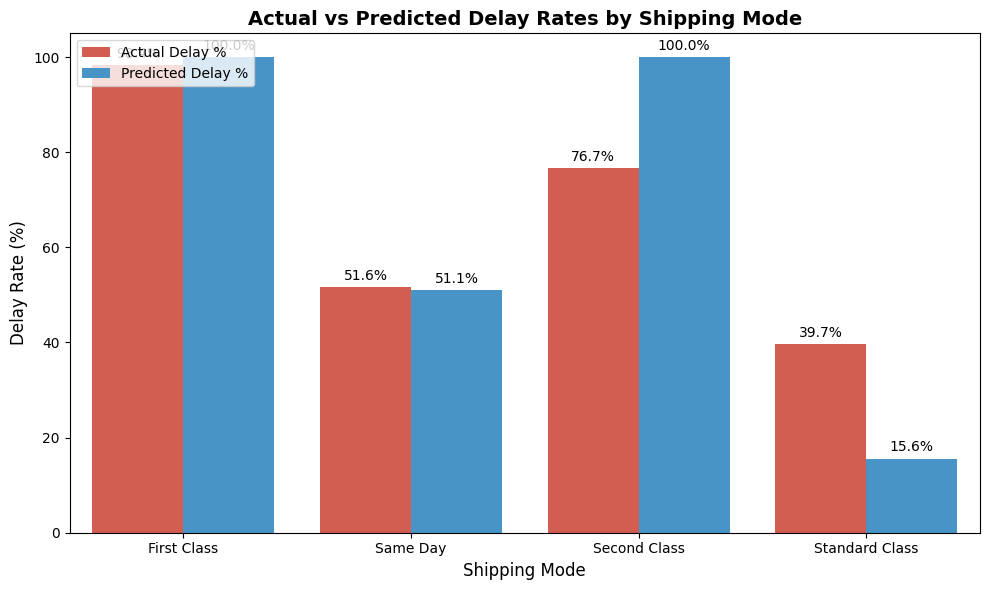

Delay rate chart created

Second Class:
  Orders: 827
  Accuracy: 76.7%

Standard Class:
  Orders: 2264
  Accuracy: 63.6%

Same Day:
  Orders: 190
  Accuracy: 72.1%

First Class:
  Orders: 607
  Accuracy: 98.4%



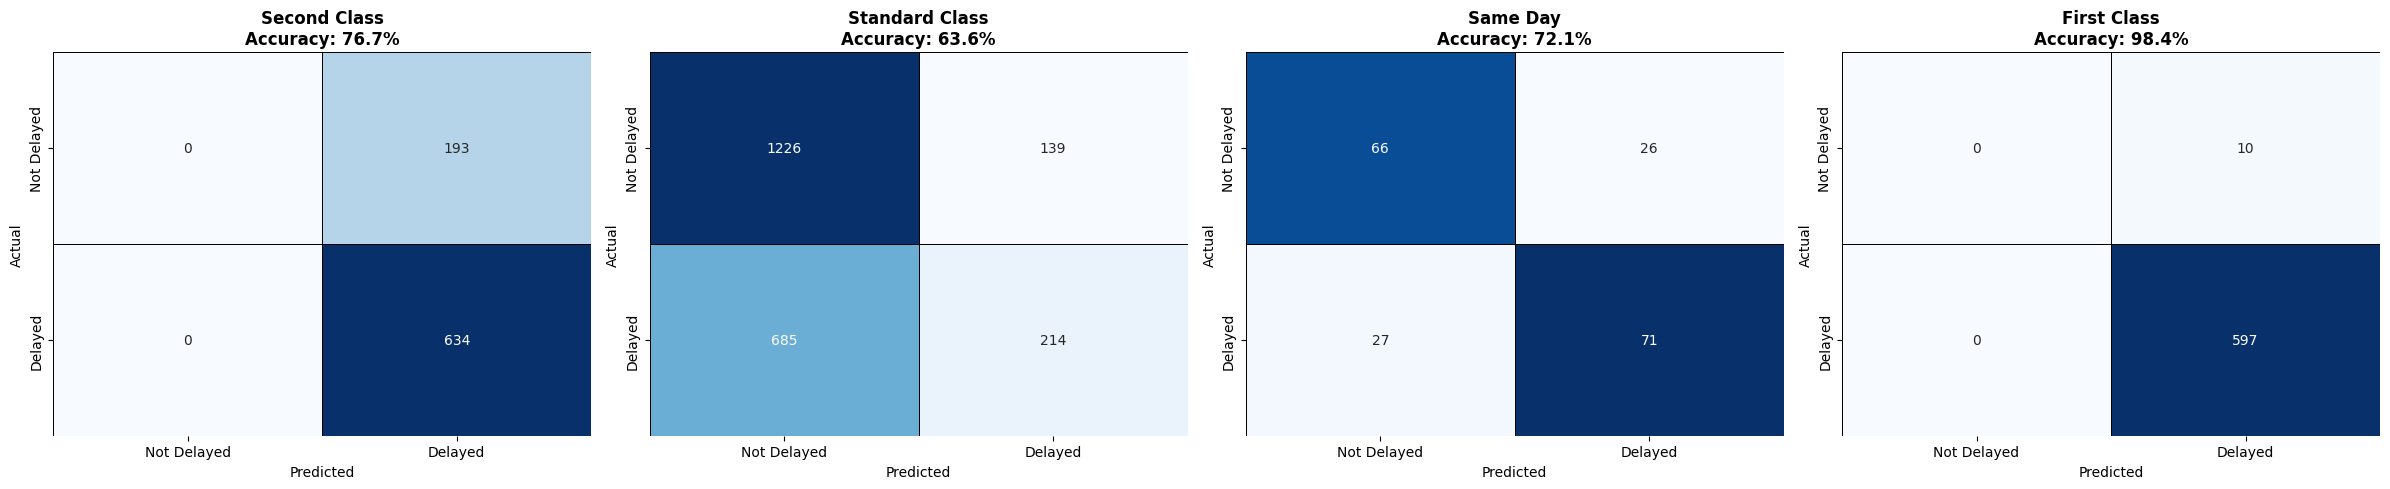

Confusion matrices created

SHIPPING MODE SUMMARY
                Orders  Actual Rate  Predicted Rate  Difference
shipping_mode                                                  
First Class        607        0.984           1.000       0.016
Same Day           190        0.516           0.511      -0.005
Second Class       827        0.767           1.000       0.233
Standard Class    2264        0.397           0.156      -0.241

Analysis complete!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency


# STEP 1: Load and clean the data


data = pd.read_csv('incom2024_delay_example_dataset.csv')
info = pd.read_csv('incom2024_delay_variable_description.csv')
categories = list(info[info['type'] == 'categorical']['variable_name'])

print(f"Loaded {len(data)} orders\n")


# STEP 2: Group rare locations


locations = {'customer_city': 50, 'customer_state': 50, 'order_city': 50,
             'order_country': 50, 'order_region': 100, 'order_state': 50}

for place, min_count in locations.items():
    counts = data[place].value_counts()
    rare = counts[counts < min_count].index
    data[place] = data[place].apply(lambda x: 'Others' if x in rare else x)

print("Rare locations grouped\n")


# STEP 3: Remove unhelpful features


# Test which categories matter
useless = []
for cat in categories:
    if cat != 'label':
        table = pd.crosstab(data[cat], data['label'])
        _, p_value, _, _ = chi2_contingency(table)
        if p_value >= 0.1:
            useless.append(cat)

data = data.drop(useless, axis=1, errors='ignore')

# Remove duplicates and text
duplicates = ['order_id', 'order_customer_id', 'product_card_id', 'category_id',
              'order_item_cardprod_id', 'order_item_total_amount', 'order_item_product_price',
              'sales', 'product_price', 'product_category_id', 'profit_per_order']
text = ['category_name', 'customer_zipcode', 'department_name', 'product_name']

data = data.drop(duplicates + text, axis=1, errors='ignore')
print(f"Removed {len(useless) + len(duplicates) + len(text)} unhelpful features\n")


# STEP 4: Calculate processing time


data['order_date'] = pd.to_datetime(data['order_date'], utc=True)
data['shipping_date'] = pd.to_datetime(data['shipping_date'], utc=True)
data['processingTime'] = (data['shipping_date'] - data['order_date']).dt.days

# Keep original before encoding (we need shipping_mode later)
original_data = data.copy()
data = data.drop(['order_date', 'shipping_date'], axis=1)

print("Processing time calculated\n")

# STEP 5: Prepare for machine learning


# Convert categories to numbers
data_ready = pd.get_dummies(data, drop_first=True, dtype=int)

# Simplify delays: Early/OnTime = 0, Delayed = 1
data_ready['label'] = data_ready['label'].apply(lambda x: 0 if x in [-1, 0] else 1)

features = data_ready.drop('label', axis=1)
target = data_ready['label']

print(f"{features.shape[1]} features ready\n")


# STEP 6: Train the model


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=1
)

# Train
model = GradientBoostingClassifier(random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Training accuracy: {train_accuracy:.1%}")
print(f"Testing accuracy: {test_accuracy:.1%}\n")


# STEP 7: Analyze by shipping mode


# Get shipping modes for test orders
test_orders = original_data.loc[X_test.index].copy()
test_orders['actual_delay'] = y_test.values
test_orders['predicted_delay'] = predictions

# Calculate rates for each shipping mode
shipping_stats = test_orders.groupby('shipping_mode').agg({
    'actual_delay': 'mean',
    'predicted_delay': 'mean'
})

shipping_stats = shipping_stats * 100  # Convert to percentage
shipping_stats.columns = ['Actual Delay %', 'Predicted Delay %']

print("Delay Rates by Shipping Mode:")
print(shipping_stats.round(1))
print()


# STEP 8: Visualize delay rates


# Prepare data for plotting
plot_data = shipping_stats.reset_index().melt(
    id_vars='shipping_mode',
    var_name='Type',
    value_name='Delay Rate'
)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='shipping_mode', y='Delay Rate', hue='Type', data=plot_data,
                 palette={'Actual Delay %': '#e74c3c', 'Predicted Delay %': '#3498db'})

plt.title('Actual vs Predicted Delay Rates by Shipping Mode', fontsize=14, fontweight='bold')
plt.xlabel('Shipping Mode', fontsize=12)
plt.ylabel('Delay Rate (%)', fontsize=12)
plt.legend(title='', loc='upper left')

# Add percentages on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

print("Delay rate chart created\n")


# STEP 9: Confusion matrix per mode


modes = test_orders['shipping_mode'].unique()
n_modes = len(modes)

# Create plots
fig, axes = plt.subplots(1, n_modes, figsize=(6*n_modes, 5))
if n_modes == 1:
    axes = [axes]

for i, mode in enumerate(modes):
    # Get data for this mode
    mode_orders = test_orders[test_orders['shipping_mode'] == mode]

    # Create confusion matrix
    cm = confusion_matrix(mode_orders['actual_delay'], mode_orders['predicted_delay'])
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum() if cm.sum() > 0 else 0

    print(f"{mode}:")
    print(f"  Orders: {len(mode_orders)}")
    print(f"  Accuracy: {accuracy:.1%}\n")

    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Delayed', 'Delayed'],
                yticklabels=['Not Delayed', 'Delayed'],
                linewidths=0.5, linecolor='black', ax=axes[i])

    axes[i].set_title(f'{mode}\nAccuracy: {accuracy:.1%}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicted', fontsize=10)
    axes[i].set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.show()

print("Confusion matrices created\n")


# STEP 10: Summary table


summary = test_orders.groupby('shipping_mode').agg({
    'actual_delay': ['count', 'mean'],
    'predicted_delay': 'mean'
})

summary.columns = ['Orders', 'Actual Rate', 'Predicted Rate']
summary['Difference'] = summary['Predicted Rate'] - summary['Actual Rate']
summary = summary.round(3)


print("SHIPPING MODE SUMMARY")

print(summary)
print()

# Done!

print("Analysis complete!")


--- Model Performance ---
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      1644
           1       0.80      0.67      0.73      2244

    accuracy                           0.71      3888
   macro avg       0.71      0.72      0.71      3888
weighted avg       0.73      0.71      0.71      3888



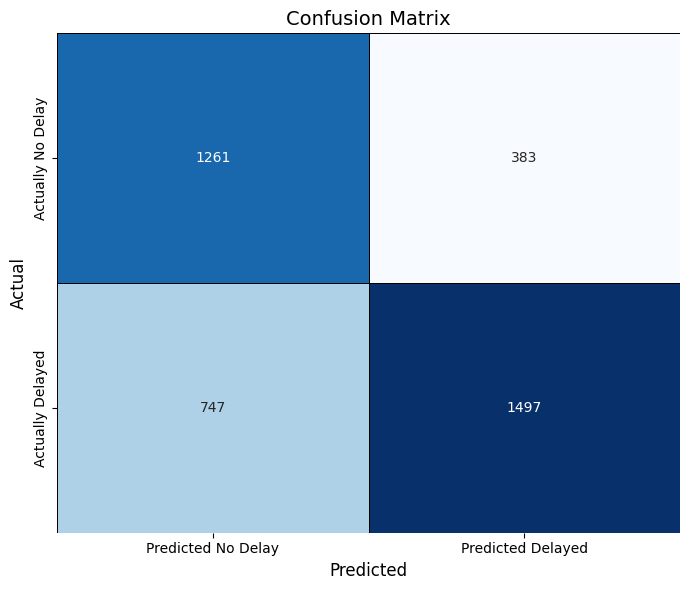


--- Delay Rates by Category ---
| Category             |   Actual Delay Rate (%) |   Predicted Delay Rate (%) |
|:---------------------|------------------------:|---------------------------:|
| Cameras              |                   71.43 |                      57.14 |
| Women's Clothing     |                   71.43 |                      50    |
| Golf Gloves          |                   67.57 |                      48.65 |
| Video Games          |                   66.67 |                      47.62 |
| Golf Shoes           |                   66.67 |                      41.67 |
| Children's Clothing  |                   65    |                      55    |
| Trade-In             |                   64.71 |                      52.94 |
| Girls' Apparel       |                   61.9  |                      52.38 |
| Golf Balls           |                   60.53 |                      36.84 |
| Others               |                   60.14 |                      46.38 |
| Elect

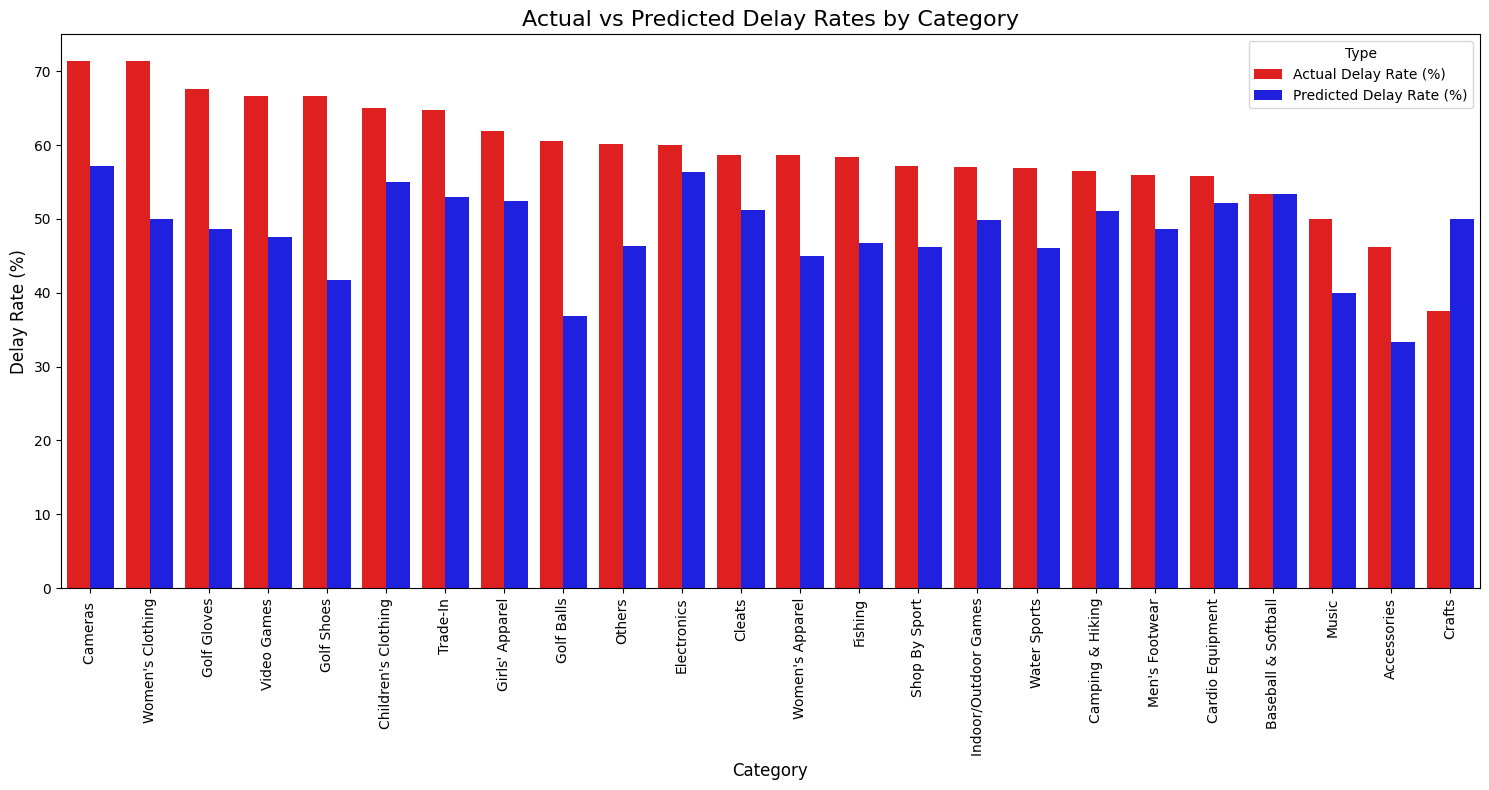

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import chi2_contingency

# Load data
df = pd.read_csv('incom2024_delay_example_dataset.csv')
dtypes = pd.read_csv('incom2024_delay_variable_description.csv')
categorical_columns = list(dtypes[dtypes['type'] == 'categorical']['variable_name'])

# Group rare categories into 'Others'
def simplify_categories(df, column, min_count):
    counts = df[column].value_counts()
    rare_values = counts[counts < min_count].index
    df[column] = df[column].apply(lambda x: 'Others' if x in rare_values else x)
    return df

# Clean up location and product columns
df = simplify_categories(df, 'customer_city', 50)
df = simplify_categories(df, 'customer_state', 50)
df = simplify_categories(df, 'order_city', 50)
df = simplify_categories(df, 'order_country', 50)
df = simplify_categories(df, 'order_region', 100)
df = simplify_categories(df, 'order_state', 50)
df = simplify_categories(df, 'product_name', 50)
df = simplify_categories(df, 'category_name', 50)

# Remove columns that don't help predict delays (chi-square test)
columns_to_check = categorical_columns + ['product_name', 'category_name']
unimportant_columns = []

for col in columns_to_check:
    if col == 'label':
        continue
    if len(df['label'].unique()) < 2 or len(df[col].unique()) < 2:
        continue

    crosstab = pd.crosstab(df[col], df['label'])
    chi_test = chi2_contingency(crosstab)

    if chi_test.pvalue >= 0.1:  # Not statistically significant
        unimportant_columns.append(col)

df = df.drop(unimportant_columns, axis=1, errors='ignore')

# Remove redundant or unhelpful columns
unnecessary_columns = [
    'order_id', 'order_customer_id', 'product_card_id',
    'order_item_cardprod_id', 'order_item_total_amount',
    'order_item_product_price', 'sales', 'product_price',
    'profit_per_order', 'product_category_id', 'category_id',
    'customer_zipcode', 'department_name'
]
df = df.drop(unnecessary_columns, axis=1, errors='ignore')

# Create processing time feature (days between order and shipping)
df['processingTime'] = (pd.to_datetime(df['shipping_date'], utc=True) -
                        pd.to_datetime(df['order_date'], utc=True)).dt.days

date_columns = list(dtypes[dtypes['type'] == 'datetime']['variable_name'])
df = df.drop(date_columns, axis=1)

# Convert text categories to numbers
df = pd.get_dummies(df, drop_first=True, dtype=int)

# Simplify delay labels: 0 = No Delay, 1 = Delay
df['label'] = df['label'].apply(lambda x: 0 if x in [-1, 0] else 1)

# Split data into features and target
X = df.drop('label', axis=1)
y = df['label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# Train the model
model = GradientBoostingClassifier(random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Show model performance
print("--- Model Performance ---")
print(classification_report(y_test, predictions))

# Create confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm,
    index=['Actually No Delay', 'Actually Delayed'],
    columns=['Predicted No Delay', 'Predicted Delayed']
)

# Visualize confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False,
            linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze by category
original_df = pd.read_csv('incom2024_delay_example_dataset.csv')
original_df = simplify_categories(original_df, 'category_name', 50)

test_results = pd.DataFrame({
    'category': original_df.loc[X_test.index, 'category_name'],
    'actual': y_test.values,
    'predicted': predictions
})

# Calculate delay rates per category
category_stats = pd.DataFrame({
    'Category': test_results.groupby('category')['actual'].mean().index,
    'Actual Delay Rate (%)': (test_results.groupby('category')['actual'].mean() * 100).round(2).values,
    'Predicted Delay Rate (%)': (test_results.groupby('category')['predicted'].mean() * 100).round(2).values
}).sort_values('Actual Delay Rate (%)', ascending=False)

print("\n--- Delay Rates by Category ---")
print(category_stats.to_markdown(index=False))

# Visualize delay rates
plot_data = category_stats.melt(
    id_vars='Category',
    var_name='Type',
    value_name='Rate'
)

plt.figure(figsize=(15, 8))
sns.barplot(x='Category', y='Rate', hue='Type', data=plot_data,
            palette={'Actual Delay Rate (%)': 'red',
                    'Predicted Delay Rate (%)': 'blue'})
plt.title('Actual vs Predicted Delay Rates by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Delay Rate (%)', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Type')
plt.tight_layout()
plt.show()

--- How Well Does The Model Predict Delays? ---
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      1644
           1       0.80      0.67      0.73      2244

    accuracy                           0.71      3888
   macro avg       0.71      0.72      0.71      3888
weighted avg       0.73      0.71      0.71      3888



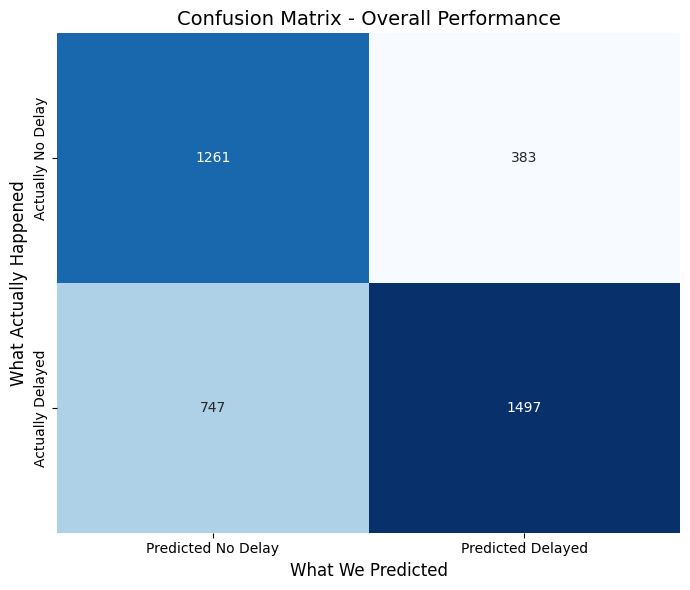


--- Results By Customer Segment ---

>>> Customer Segment: Corporate
              precision    recall  f1-score   support

           0       0.65      0.75      0.69       504
           1       0.79      0.69      0.74       670

    accuracy                           0.72      1174
   macro avg       0.72      0.72      0.71      1174
weighted avg       0.73      0.72      0.72      1174



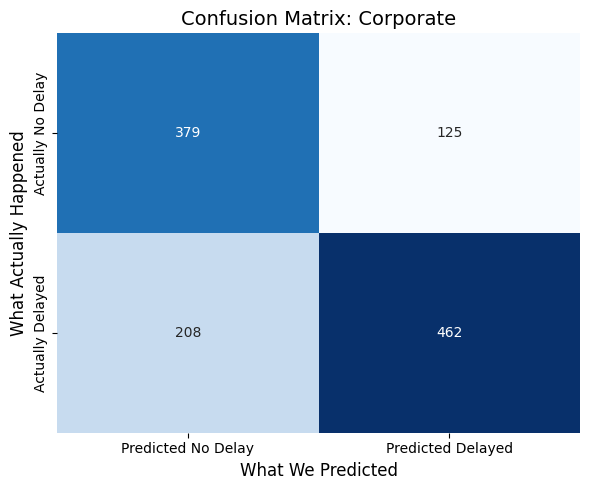


>>> Customer Segment: Consumer
              precision    recall  f1-score   support

           0       0.62      0.77      0.69       865
           1       0.80      0.66      0.72      1203

    accuracy                           0.71      2068
   macro avg       0.71      0.72      0.70      2068
weighted avg       0.72      0.71      0.71      2068



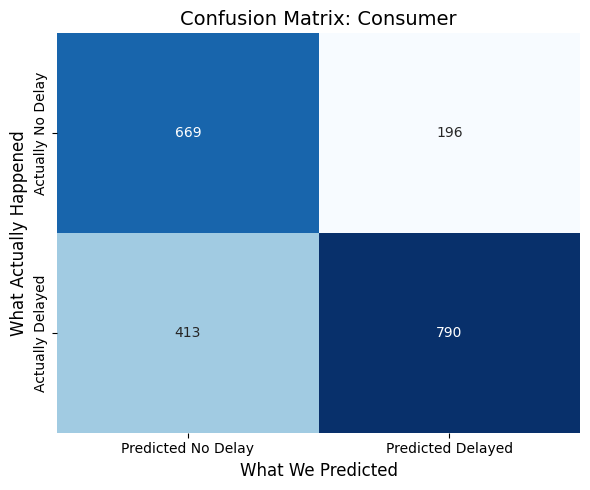


>>> Customer Segment: Home Office
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       275
           1       0.80      0.66      0.72       371

    accuracy                           0.71       646
   macro avg       0.71      0.72      0.71       646
weighted avg       0.73      0.71      0.71       646



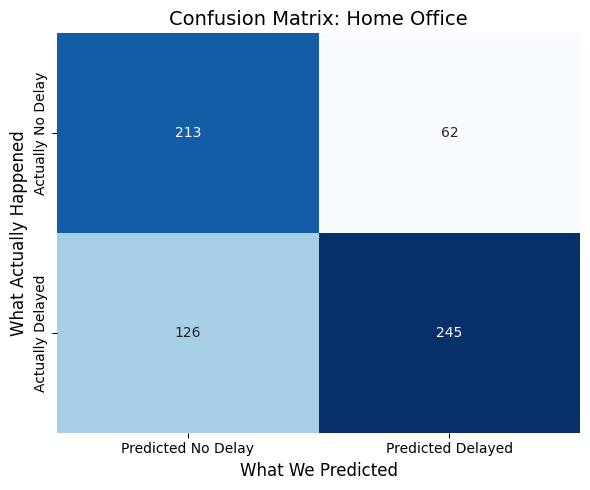


--- Delay Rates By Customer Segment ---
| Customer Segment   |   Actual Delay (%) |   Predicted Delay (%) |
|:-------------------|-------------------:|----------------------:|
| Consumer           |              58.17 |                 47.68 |
| Home Office        |              57.43 |                 47.52 |
| Corporate          |              57.07 |                 50    |


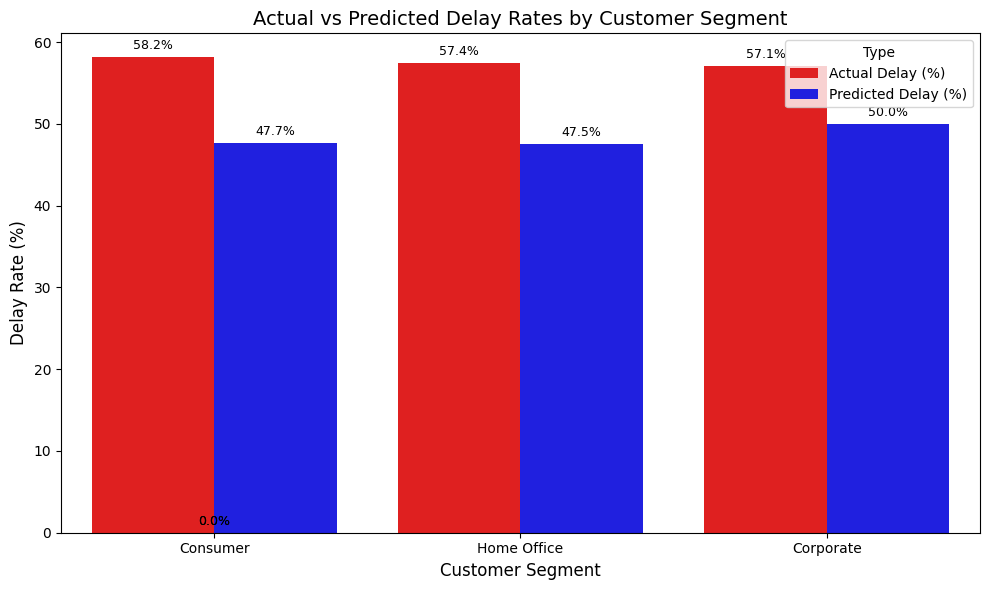

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import chi2_contingency


# STEP 1: Load the data

df = pd.read_csv('incom2024_delay_example_dataset.csv')
dtypes = pd.read_csv('incom2024_delay_variable_description.csv')


# STEP 2: Clean up rare categories

def group_rare_items(df, column, minimum_count):
    """If a category appears less than minimum_count times, call it 'Others'"""
    counts = df[column].value_counts()
    rare_items = counts[counts < minimum_count].index
    df[column] = df[column].replace(rare_items, 'Others')
    return df

# Group rare categories in location and product columns
df = group_rare_items(df, 'customer_city', 50)
df = group_rare_items(df, 'customer_state', 50)
df = group_rare_items(df, 'order_city', 50)
df = group_rare_items(df, 'order_country', 50)
df = group_rare_items(df, 'order_region', 100)
df = group_rare_items(df, 'order_state', 50)
df = group_rare_items(df, 'product_name', 50)
df = group_rare_items(df, 'category_name', 50)


# STEP 3: Remove columns that don't help predict delays

categorical_cols = list(dtypes[dtypes['type'] == 'categorical']['variable_name'])
columns_to_test = categorical_cols + ['product_name', 'category_name']

# Test each column to see if it's related to delays
unrelated_columns = []
for col in columns_to_test:
    if col == 'label':
        continue

    # Skip if not enough variety in the data
    if len(df['label'].unique()) < 2 or len(df[col].unique()) < 2:
        continue

    # Statistical test: is this column related to delays?
    table = pd.crosstab(df[col], df['label'])
    test = chi2_contingency(table)

    # If p-value >= 0.1, the column doesn't help predict delays
    if test.pvalue >= 0.1:
        unrelated_columns.append(col)

df = df.drop(unrelated_columns, axis=1, errors='ignore')


# STEP 4: Remove unnecessary columns

columns_to_remove = [
    'order_id', 'order_customer_id', 'product_card_id',
    'order_item_cardprod_id', 'order_item_total_amount',
    'order_item_product_price', 'sales', 'product_price',
    'profit_per_order', 'product_category_id', 'category_id',
    'customer_zipcode', 'department_name'
]
df = df.drop(columns_to_remove, axis=1, errors='ignore')


# STEP 5: Create a new feature: processing time (in days)

order_date = pd.to_datetime(df['order_date'], utc=True)
shipping_date = pd.to_datetime(df['shipping_date'], utc=True)
df['processingTime'] = (shipping_date - order_date).dt.days

# Remove the original date columns
date_columns = list(dtypes[dtypes['type'] == 'datetime']['variable_name'])
df = df.drop(date_columns, axis=1)


# STEP 6: Convert categories to numbers

df = pd.get_dummies(df, drop_first=True, dtype=int)


# STEP 7: Simplify delay labels

# 0 or -1 = No Delay → 0
# 1 = Delay → 1
df['label'] = df['label'].apply(lambda x: 0 if x in [-1, 0] else 1)


# STEP 8: Split data into training and testing

X = df.drop('label', axis=1)  # Features
y = df['label']  # Target (delay or no delay)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)


# STEP 9: Train the prediction model

model = GradientBoostingClassifier(random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)


# STEP 10: Check how well the model works

print("--- How Well Does The Model Predict Delays? ---")
print(classification_report(y_test, predictions))


# STEP 11: Show confusion matrix

cm = confusion_matrix(y_test, predictions)
cm_labels = pd.DataFrame(
    cm,
    index=['Actually No Delay', 'Actually Delayed'],
    columns=['Predicted No Delay', 'Predicted Delayed']
)

plt.figure(figsize=(7, 6))
sns.heatmap(cm_labels, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Overall Performance', fontsize=14)
plt.xlabel('What We Predicted', fontsize=12)
plt.ylabel('What Actually Happened', fontsize=12)
plt.tight_layout()
plt.show()


# STEP 12: Analyze by customer segment

# Load original data to get customer segments
original_data = pd.read_csv('incom2024_delay_example_dataset.csv')

# Create analysis table
test_results = pd.DataFrame({
    'segment': original_data.loc[X_test.index, 'customer_segment'],
    'actual': y_test.values,
    'predicted': predictions
})

# Show results for each customer segment
segments = test_results['segment'].unique()

print("\n--- Results By Customer Segment ---")
for segment in segments:
    segment_data = test_results[test_results['segment'] == segment]

    if len(segment_data) == 0:
        continue

    print(f"\n>>> Customer Segment: {segment}")

    # Check if we have enough data
    if len(segment_data['actual'].unique()) < 2:
        print(f"Not enough data to analyze {segment}")
        continue

    # Show performance report
    print(classification_report(segment_data['actual'], segment_data['predicted'], zero_division=0))

    # Create confusion matrix for this segment
    cm = confusion_matrix(segment_data['actual'], segment_data['predicted'])
    cm_df = pd.DataFrame(
        cm,
        index=['Actually No Delay', 'Actually Delayed'],
        columns=['Predicted No Delay', 'Predicted Delayed']
    )

    # Visualize
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {segment}', fontsize=14)
    plt.xlabel('What We Predicted', fontsize=12)
    plt.ylabel('What Actually Happened', fontsize=12)
    plt.tight_layout()
    plt.show()


# STEP 13: Compare actual vs predicted delay rates

# Calculate delay percentages by segment
actual_delay_pct = test_results.groupby('segment')['actual'].mean() * 100
predicted_delay_pct = test_results.groupby('segment')['predicted'].mean() * 100

# Combine into one table
comparison = pd.DataFrame({
    'Customer Segment': actual_delay_pct.index,
    'Actual Delay (%)': actual_delay_pct.values.round(2),
    'Predicted Delay (%)': predicted_delay_pct.values.round(2)
}).sort_values('Actual Delay (%)', ascending=False)

print("\n--- Delay Rates By Customer Segment ---")
print(comparison.to_markdown(index=False))


# STEP 14: Visualize the comparison

# Reshape data for plotting
plot_data = comparison.melt(
    id_vars='Customer Segment',
    var_name='Type',
    value_name='Delay Rate'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Customer Segment',
    y='Delay Rate',
    hue='Type',
    data=plot_data,
    palette={'Actual Delay (%)': 'red', 'Predicted Delay (%)': 'blue'}
)

plt.title('Actual vs Predicted Delay Rates by Customer Segment', fontsize=14)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Delay Rate (%)', fontsize=12)
plt.legend(title='Type', loc='upper right')

# Add percentage labels on bars
for bar in plt.gca().patches:
    height = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()

Loading data...


/tmp/ipython-input-3069014016.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['processing_time_days'].fillna(df['processing_time_days'].median(), inplace=True)


✓ Data loaded: 15549 rows, 42 columns

PREDICTING SALES BY PRODUCT CATEGORY

Linear Regression:
  Average Error: $10.24
  Accuracy (R²): 0.9355

Random Forest:
  Average Error: $3.71
  Accuracy (R²): 0.9567

Gradient Boosting:
  Average Error: $6.08
  Accuracy (R²): 0.9787

WINNER: Gradient Boosting with R² = 0.9787


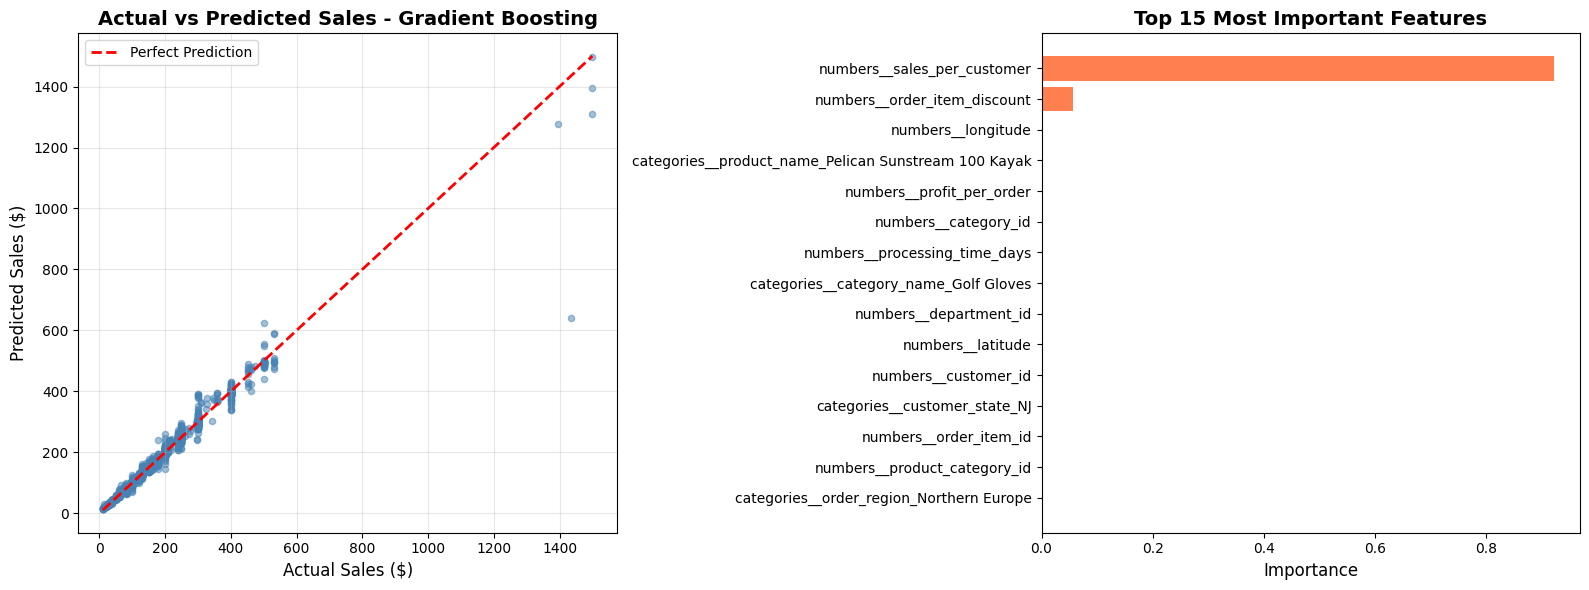


Top 10 Categories by Average Sales:
      category_name  Actual_Sales  Predicted_Sales
           Cameras     452.040000       456.191496
            Fishing    399.980000       399.169917
Children's Clothing    335.231551       347.293596
   Camping & Hiking    300.315632       300.996972
   Cardio Equipment    282.266267       282.111957
   Women's Clothing    225.416360       216.271704
              Music    223.044420       208.763118
             Others    212.340243       205.650356
         Golf Shoes    206.727095       218.691940
       Water Sports    199.990038       199.426217


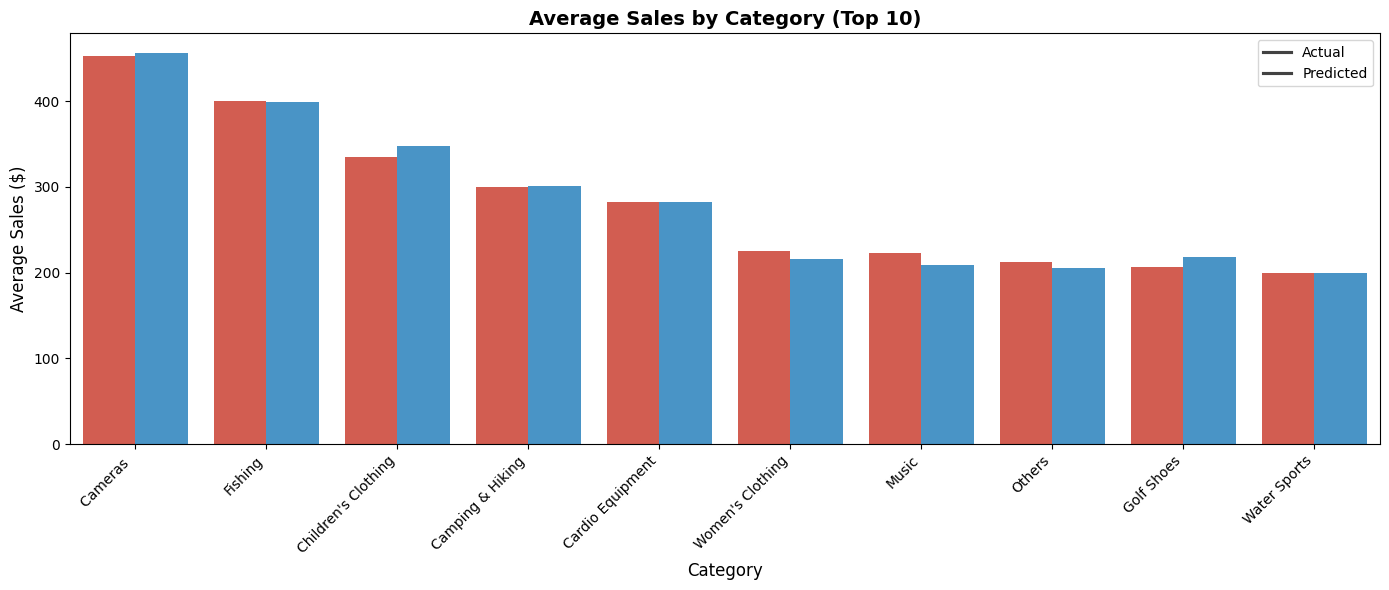


PREDICTING DAILY PRODUCT DEMAND
Creating time-based features...
✓ Daily demand data ready: 7468 rows

Linear Regression:
  Average Error: 1.94 units
  Accuracy (R²): 0.4789

Random Forest:
  Average Error: 2.05 units
  Accuracy (R²): 0.4199

Gradient Boosting:
  Average Error: 1.96 units
  Accuracy (R²): 0.4622

WINNER: Linear Regression with R² = 0.4789

Top 10 Products by Daily Demand:
                                 product_name  Actual_Demand  Predicted_Demand
             Perfect Fitness Perfect Rip Deck       8.124260          7.491666
         Nike Men's Dri-FIT Victory Golf Polo       6.980892          7.125379
             O'Brien Men's Neoprene Life Vest       6.445122          6.269606
            Nike Men's Free 5.0+ Running Shoe       5.171171          4.777743
Under Armour Girls' Toddler Spine Surge Runni       4.968504          4.975997
                                       Others       4.436261          4.595430
      Nike Men's CJ Elite 2 TD Football Cleat       2.2

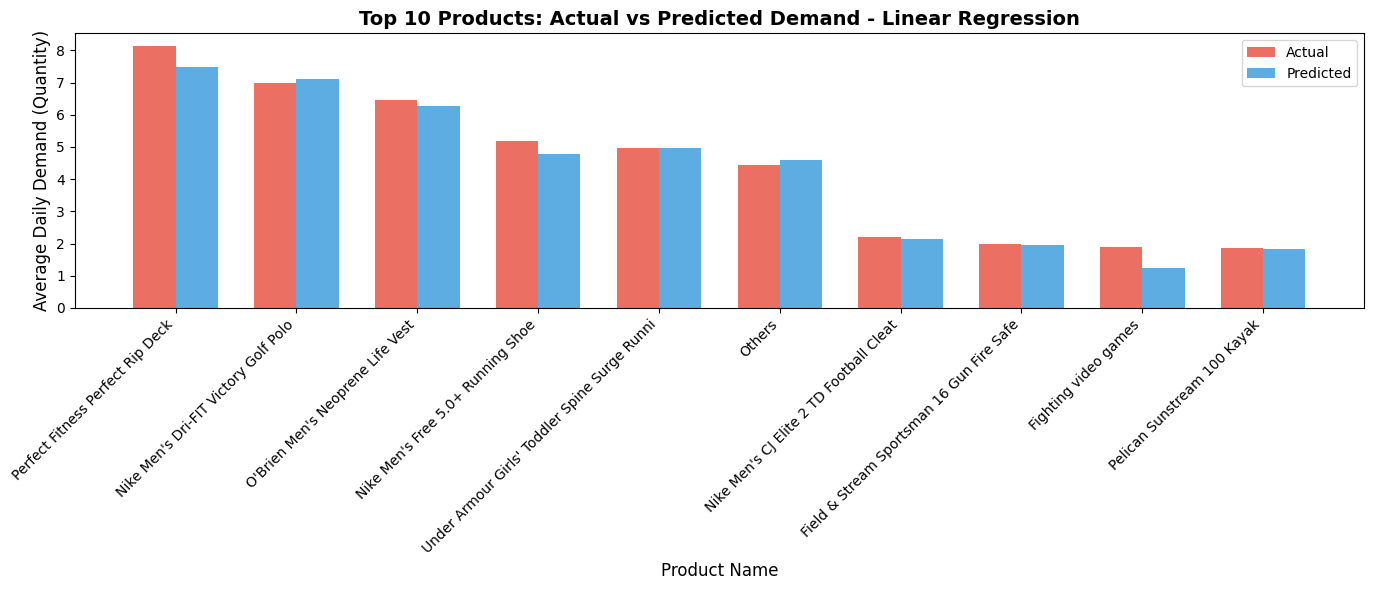


✓ ANALYSIS COMPLETE!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# STEP 1: Load and Clean the Data


df = pd.read_csv('incom2024_delay_example_dataset.csv')

# Convert dates and calculate processing time
df['order_date'] = pd.to_datetime(df['order_date'], utc=True, errors='coerce')
df['shipping_date'] = pd.to_datetime(df['shipping_date'], utc=True, errors='coerce')
df['processing_time_days'] = (df['shipping_date'] - df['order_date']).dt.days
df['processing_time_days'].fillna(df['processing_time_days'].median(), inplace=True)

# Group rare categories into 'Others'
def simplify_column(df, column, min_count):
    """If a value appears less than min_count times, replace it with 'Others'"""
    counts = df[column].value_counts()
    rare_values = counts[counts < min_count].index
    df[column] = df[column].replace(rare_values, 'Others')
    return df

# Clean up location and product columns
df = simplify_column(df, 'customer_city', 50)
df = simplify_column(df, 'customer_state', 50)
df = simplify_column(df, 'order_city', 50)
df = simplify_column(df, 'order_country', 50)
df = simplify_column(df, 'order_region', 100)
df = simplify_column(df, 'order_state', 50)
df = simplify_column(df, 'product_name', 50)
df = simplify_column(df, 'category_name', 50)

print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# STEP 2: Predict Sales by Category





# Remove columns we don't need for prediction
columns_to_remove = [
    'sales', 'order_id', 'order_customer_id', 'product_card_id',
    'order_item_cardprod_id', 'order_item_total_amount',
    'order_item_product_price', 'product_price', 'customer_zipcode',
    'department_name', 'order_date', 'shipping_date', 'label'
]

X = df.drop(columns=columns_to_remove, errors='ignore')
y = df['sales']

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate numeric and text columns
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
text_cols = X_train.select_dtypes(include='object').columns.tolist()

# Create a data processor
preprocessor = ColumnTransformer([
    ('numbers', StandardScaler(), numeric_cols),
    ('categories', OneHotEncoder(handle_unknown='ignore'), text_cols)
])

# Try three different models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train each model and check performance
results = {}
for model_name, model in models.items():
    # Create pipeline: preprocess → train → predict
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    # Calculate how good the predictions are
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    results[model_name] = {
        'MAE': mae,
        'R2': r2,
        'predictions': predictions,
        'pipeline': pipeline
    }

    print(f"\n{model_name}:")
    print(f"  Average Error: ${mae:.2f}")
    print(f"  Accuracy (R²): {r2:.4f}")

# Find the best model
best_model = max(results, key=lambda k: results[k]['R2'])
best_predictions = results[best_model]['predictions']

print(f"\n{'='*70}")
print(f"WINNER: {best_model} with R² = {results[best_model]['R2']:.4f}")
print(f"{'='*70}")


# STEP 3: Visualize Actual vs Predicted Sales

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Scatter plot
axes[0].scatter(y_test, best_predictions, alpha=0.5, s=20, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Sales ($)', fontsize=12)
axes[0].set_ylabel('Predicted Sales ($)', fontsize=12)
axes[0].set_title(f'Actual vs Predicted Sales - {best_model}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: Feature importance
pipeline = results[best_model]['pipeline']
if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    feature_names = preprocessor.get_feature_names_out()
    importances = pipeline.named_steps['model'].feature_importances_

    # Get top 15 most important features
    top_15 = pd.Series(importances, index=feature_names).nlargest(15)

    axes[1].barh(range(len(top_15)), top_15.values, color='coral')
    axes[1].set_yticks(range(len(top_15)))
    axes[1].set_yticklabels(top_15.index, fontsize=10)
    axes[1].set_xlabel('Importance', fontsize=12)
    axes[1].set_title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
else:
    axes[1].text(0.5, 0.5, 'Feature importance not available',
                 ha='center', va='center', fontsize=12)
    axes[1].axis('off')

plt.tight_layout()
plt.show()


# STEP 4: Analyze Sales by Category

# Add predictions to test data
test_data = df.loc[y_test.index].copy()
test_data['Actual_Sales'] = y_test.values
test_data['Predicted_Sales'] = best_predictions

# Calculate average sales per category
category_sales = test_data.groupby('category_name')[
    ['Actual_Sales', 'Predicted_Sales']
].mean().sort_values('Actual_Sales', ascending=False).reset_index()

print(f"\nTop 10 Categories by Average Sales:")
print(category_sales.head(10).to_string(index=False))

# Visualize top 10 categories
top_10 = category_sales.head(10)
plot_data = top_10.melt(id_vars='category_name', var_name='Type', value_name='Sales')

plt.figure(figsize=(14, 6))
sns.barplot(x='category_name', y='Sales', hue='Type', data=plot_data,
            palette={'Actual_Sales': '#e74c3c', 'Predicted_Sales': '#3498db'})
plt.title('Average Sales by Category (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Sales ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='', labels=['Actual', 'Predicted'])
plt.tight_layout()
plt.show()


# STEP 5: Predict Product Demand (Daily Quantities)





# Create daily demand data
df['order_day'] = df['order_date'].dt.date
daily_demand = df.groupby(['order_day', 'product_name']).agg({
    'order_item_quantity': 'sum'
}).reset_index()

daily_demand['order_day'] = pd.to_datetime(daily_demand['order_day'])
daily_demand = daily_demand.sort_values(['product_name', 'order_day'])

# Create helpful features for each product
print("Creating time-based features...")
for product in daily_demand['product_name'].unique():
    mask = daily_demand['product_name'] == product

    # Yesterday's demand
    daily_demand.loc[mask, 'demand_yesterday'] = \
        daily_demand.loc[mask, 'order_item_quantity'].shift(1)

    # Demand 7 days ago
    daily_demand.loc[mask, 'demand_last_week'] = \
        daily_demand.loc[mask, 'order_item_quantity'].shift(7)

    # Average demand over last 7 days
    daily_demand.loc[mask, 'avg_demand_7days'] = \
        daily_demand.loc[mask, 'order_item_quantity'].rolling(7).mean()

    # Average demand over last 30 days
    daily_demand.loc[mask, 'avg_demand_30days'] = \
        daily_demand.loc[mask, 'order_item_quantity'].rolling(30).mean()

# Add date features
daily_demand['month'] = daily_demand['order_day'].dt.month
daily_demand['day_of_week'] = daily_demand['order_day'].dt.dayofweek

# Remove rows with missing values (from lagging/rolling)
daily_demand = daily_demand.dropna()
print(f"✓ Daily demand data ready: {daily_demand.shape[0]} rows")

# Prepare features and target
X_demand = daily_demand.drop(['order_day', 'order_item_quantity'], axis=1)
y_demand = daily_demand['order_item_quantity']

# Split data
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_demand, y_demand, test_size=0.2, random_state=42
)

# Create preprocessor
numeric_features = X_train_d.select_dtypes(include=np.number).columns.tolist()
category_features = ['product_name']

preprocessor_demand = ColumnTransformer([
    ('numbers', StandardScaler(), numeric_features),
    ('categories', OneHotEncoder(handle_unknown='ignore'), category_features)
])

# Train models
demand_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

demand_results = {}
for model_name, model in demand_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_demand),
        ('model', model)
    ])

    pipeline.fit(X_train_d, y_train_d)
    predictions = pipeline.predict(X_test_d)

    mae = mean_absolute_error(y_test_d, predictions)
    r2 = r2_score(y_test_d, predictions)

    demand_results[model_name] = {
        'MAE': mae,
        'R2': r2,
        'predictions': predictions
    }

    print(f"\n{model_name}:")
    print(f"  Average Error: {mae:.2f} units")
    print(f"  Accuracy (R²): {r2:.4f}")

# Find best model
best_demand_model = max(demand_results, key=lambda k: demand_results[k]['R2'])
best_demand_predictions = demand_results[best_demand_model]['predictions']

print(f"\n{'='*70}")
print(f"WINNER: {best_demand_model} with R² = {demand_results[best_demand_model]['R2']:.4f}")
print(f"{'='*70}")


# STEP 6: Analyze Demand by Product

# Add predictions to test data
test_demand = X_test_d.copy()
test_demand['Actual_Demand'] = y_test_d.values
test_demand['Predicted_Demand'] = best_demand_predictions

# Calculate average demand per product
product_demand = test_demand.groupby('product_name')[
    ['Actual_Demand', 'Predicted_Demand']
].mean().sort_values('Actual_Demand', ascending=False).head(10).reset_index()

print(f"\nTop 10 Products by Daily Demand:")
print(product_demand.to_string(index=False))

# Visualize top 10 products
x_positions = np.arange(len(product_demand))
bar_width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x_positions - bar_width/2, product_demand['Actual_Demand'],
        bar_width, label='Actual', color='#e74c3c', alpha=0.8)
plt.bar(x_positions + bar_width/2, product_demand['Predicted_Demand'],
        bar_width, label='Predicted', color='#3498db', alpha=0.8)

plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Average Daily Demand (Quantity)', fontsize=12)
plt.title(f'Top 10 Products: Actual vs Predicted Demand - {best_demand_model}',
          fontsize=14, fontweight='bold')
plt.xticks(x_positions, product_demand['product_name'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


print("ANALYSIS COMPLETE!")


Loading order data...
✓ Loaded 1159 days of order data

Creating prediction features...
✓ Created 7 features
✓ Ready to analyze 1129 days

Splitting data...
Training period: 2015-01-31 to 2017-07-23
Testing period: 2017-07-24 to 2018-12-01
Training days: 903
Testing days: 226

TRAINING MODELS TO PREDICT ORDER VOLUME

Training Linear Regression...
  Average Error: 5.09 orders
  Accuracy (R²): 0.7543

Training Random Forest...
  Average Error: 11.19 orders
  Accuracy (R²): 0.1712

Training Gradient Boosting...
  Average Error: 10.59 orders
  Accuracy (R²): 0.2415

WINNER: Linear Regression
Accuracy (R²): 0.7543
Average Error: 5.09 orders



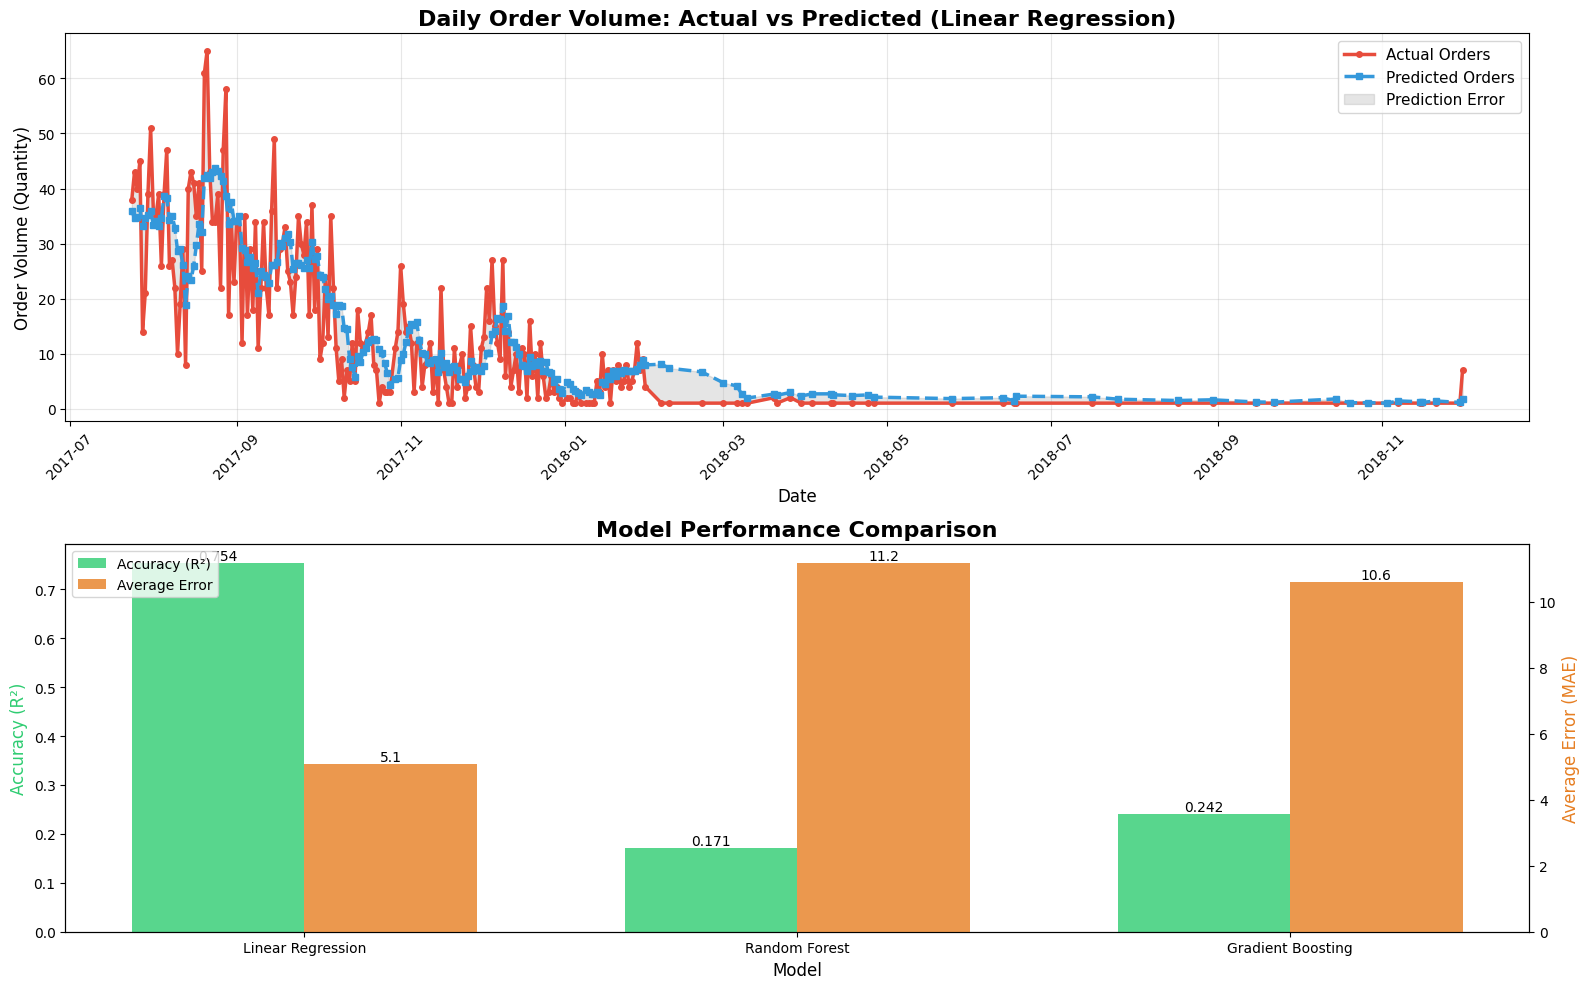

SAMPLE PREDICTIONS (First 10 Test Days)
      Date  Actual  Predicted  Difference  Error %
2017-07-24      38         35           2      5.4
2017-07-25      43         34           8     19.6
2017-07-26      40         34           5     13.1
2017-07-27      45         36           8     19.1
2017-07-28      14         33         -19   -136.8
2017-07-29      21         34         -13    -64.9
2017-07-30      39         35           3     10.0
2017-07-31      51         35          15     29.4
2017-08-01      36         33           2      7.2
2017-08-02      35         34           0      2.7

✓ ORDER VOLUME PREDICTION COMPLETE!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# STEP 1: Load the Data


df = pd.read_csv('incom2024_delay_example_dataset.csv')

# Convert to dates
df['order_date'] = pd.to_datetime(df['order_date'], utc=True, errors='coerce')
df['order_day'] = df['order_date'].dt.date

# Calculate total orders per day
daily_orders = df.groupby('order_day')['order_item_quantity'].sum()
print(f"Loaded {len(daily_orders)} days of order data\n")


# STEP 2: Create Helpful Features



# Convert to DataFrame with dates
daily_orders = daily_orders.reset_index()
daily_orders['order_day'] = pd.to_datetime(daily_orders['order_day'])
daily_orders = daily_orders.set_index('order_day').sort_index()

# Add yesterday's orders
daily_orders['orders_yesterday'] = daily_orders['order_item_quantity'].shift(1)

# Add last week's orders
daily_orders['orders_last_week'] = daily_orders['order_item_quantity'].shift(7)

# Add last month's orders
daily_orders['orders_last_month'] = daily_orders['order_item_quantity'].shift(30)

# Add average orders over last 7 days
daily_orders['avg_orders_7days'] = daily_orders['order_item_quantity'].rolling(7).mean()

# Add average orders over last 30 days
daily_orders['avg_orders_30days'] = daily_orders['order_item_quantity'].rolling(30).mean()

# Add month (for seasonal patterns)
daily_orders['month'] = daily_orders.index.month

# Add day of week (Monday=0, Sunday=6)
daily_orders['day_of_week'] = daily_orders.index.dayofweek

# Remove rows with missing data (from creating features above)
daily_orders = daily_orders.dropna()

print(f"Created {daily_orders.shape[1] - 1} features")
print(f"Ready to analyze {len(daily_orders)} days\n")


# STEP 3: Split Data for Training and Testing



# Separate features from target
X = daily_orders.drop('order_item_quantity', axis=1)  # Features
y = daily_orders['order_item_quantity']  # Target (what we want to predict)

# Split chronologically (80% train, 20% test)
# Important: we don't shuffle because time order matters!
split_point = int(len(daily_orders) * 0.8)

X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

print(f"Training period: {X_train.index[0].date()} to {X_train.index[-1].date()}")
print(f"Testing period: {X_test.index[0].date()} to {X_test.index[-1].date()}")
print(f"Training days: {len(X_train)}")
print(f"Testing days: {len(X_test)}\n")

# Scale the features (make them similar sizes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# STEP 4: Train Different Models



# Try three different prediction methods
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train each model and check performance
results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    predictions = model.predict(X_test_scaled)

    # Calculate how good the predictions are
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store results
    results[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'predictions': predictions,
        'model': model
    }

    print(f"  Average Error: {mae:.2f} orders")
    print(f"  Accuracy (R²): {r2:.4f}")

# Find the best model
best_model = max(results, key=lambda k: results[k]['R2'])
best_predictions = results[best_model]['predictions']


print(f"WINNER: {best_model}")

print(f"Accuracy (R²): {results[best_model]['R2']:.4f}")
print(f"Average Error: {results[best_model]['MAE']:.2f} orders\n")


# STEP 5: Visualize the Results

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# TOP CHART: Actual vs Predicted Over Time
axes[0].plot(y_test.index, y_test.values,
             label='Actual Orders', linewidth=2.5, color='#e74c3c',
             marker='o', markersize=4)
axes[0].plot(y_test.index, best_predictions,
             label='Predicted Orders', linewidth=2.5, linestyle='--',
             color='#3498db', marker='s', markersize=4)
axes[0].fill_between(y_test.index, y_test.values, best_predictions,
                      alpha=0.2, color='gray', label='Prediction Error')

axes[0].set_title(f'Daily Order Volume: Actual vs Predicted ({best_model})',
                  fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Order Volume (Quantity)', fontsize=12)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# BOTTOM CHART: Model Comparison
model_names = list(results.keys())
accuracies = [results[name]['R2'] for name in model_names]
errors = [results[name]['MAE'] for name in model_names]

x_positions = np.arange(len(model_names))
bar_width = 0.35

# Create two y-axes for different scales
ax2 = axes[1].twinx()

# Left bars: Accuracy (R²)
bars1 = axes[1].bar(x_positions - bar_width/2, accuracies, bar_width,
                     label='Accuracy (R²)', color='#2ecc71', alpha=0.8)

# Right bars: Average Error
bars2 = ax2.bar(x_positions + bar_width/2, errors, bar_width,
                 label='Average Error', color='#e67e22', alpha=0.8)

axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Accuracy (R²)', fontsize=12, color='#2ecc71')
ax2.set_ylabel('Average Error (MAE)', fontsize=12, color='#e67e22')
axes[1].set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
axes[1].set_xticks(x_positions)
axes[1].set_xticklabels(model_names)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# Combine legends
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


# STEP 6: Show Sample Predictions


print("SAMPLE PREDICTIONS (First 10 Test Days)")


summary = pd.DataFrame({
    'Date': y_test.index[:10],
    'Actual': y_test.values[:10].astype(int),
    'Predicted': best_predictions[:10].astype(int),
    'Difference': (y_test.values[:10] - best_predictions[:10]).astype(int),
    'Error %': ((y_test.values[:10] - best_predictions[:10]) / y_test.values[:10] * 100).round(1)
})

print(summary.to_string(index=False))


print("ORDER VOLUME PREDICTION COMPLETE!")


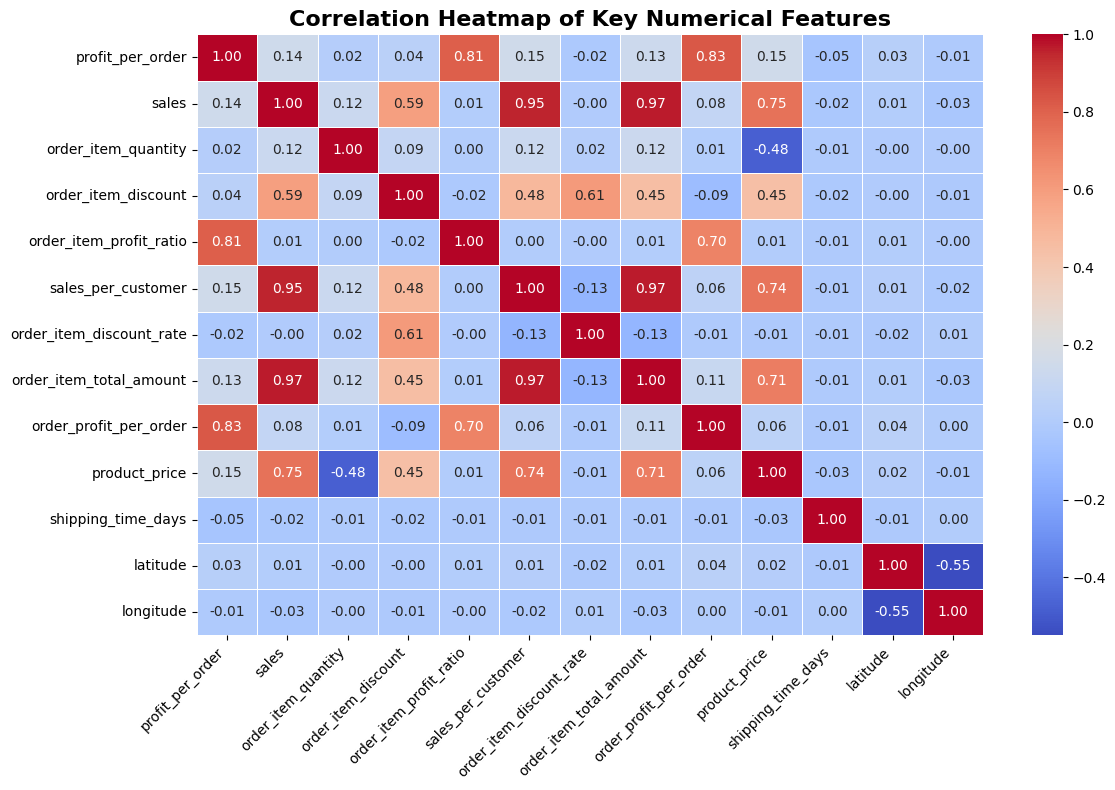

Correlation analysis complete!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('incom2024_delay_example_dataset.csv')

# Convert date columns and calculate shipping_time_days
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce', utc=True)
df['shipping_date'] = pd.to_datetime(df['shipping_date'], errors='coerce', utc=True)
df['shipping_time_days'] = (df['shipping_date'] - df['order_date']).dt.days

# Select key numerical features for correlation analysis
numerical_features = [
    'profit_per_order', 'sales', 'order_item_quantity',
    'order_item_discount', 'order_item_profit_ratio',
    'sales_per_customer', 'order_item_discount_rate',
    'order_item_total_amount', 'order_profit_per_order',
    'product_price', 'shipping_time_days',
    'latitude', 'longitude' # Include location as potentially relevant
]

# Compute the correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Key Numerical Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Correlation analysis complete!")